# Questions from chapter 3 -  probability theory

In [128]:
import numpy as np
from collections import defaultdict, Counter
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

### Q1
a. The maximum likelihood estimate of *p* for a binomial random variable is simply $ num\_event/total\_events $ which in this case would be:

$$p(h) = \frac{num\_heads}{total\_flips} = 4/10$$
$$p(t) = 1 - p(h) = 6/10$$

This could be derived by maximizing the log-likelihood of **p(D | h)** where **h** is the probability of heads. Given 10 tosses in order `HTTHTHTHTT`, the likelihood function *L(h | D)* can be expressed as:
$$L(h | D) = p(D | h) = h^4*(1 - h)^6$$

Taking log of the likelihood returns:
$$log(L) = 4*log(h) + 6*log(1 - h)$$

Taking the derivative of the negative log-likelihood returns:

$$ \frac{-dL}{dh} = \frac{4}{h} - \frac{6}{1 - h}  $$

Solving for *h* where $\frac{dL}{dh} = 0$ gives $h = \frac{2}{5}$

b. If the coin is flipped 5 times to observe HHTTH, the probability of observation by ML estimate will be $0.4^3*0.6^2 = 0.02304$. According to a uniform distribution of 0.5, the probability will be $0.5^5 = 0.03125$

### Q2

In [2]:
data = [4, 2, 6, 6, 2, 1, 4, 3, 6, 5]
print "a.", "mean =", np.mean(data), "var =", np.var(data)

a. mean = 3.9 var = 3.09


In [5]:
print "b. Assuming uniform distribution, expectation =", sum(v*1.0/6 for v in data)
print "and variance =", sum((v - 3.9)**2 * 1.0/6 for v in data)

b. Assuming uniform distribution, expectation = 6.5
and variance = 5.15


### Q3
a. Prove that $p(y|x) = p(y)$ if X and Y are independent.

Conditional probability is defined as $p(y|x) = \frac{p(x, y)}{p(x)}$. If X and Y are independent then $p(x, y) = p(x)p(y)$. Substitute and simplify.

b. $p(x|y) = \frac{p(x, y)}{p(y)}$ and $p(y|x) = \frac{p(x, y)}{p(x)}$. Substitute and simplify.

### Q6 looks interesting. Obtain a text corpus that is tokenized, such as the Europarl corpus, and take a subset of it. Collect statistics over the frequency of words and the length of words (in characters).

### a. Use the statistics to estimate probability distributions for both events, and for each event by itself.

In [177]:
with open('../data/common-test/ep-test.en') as fp:
    _word_counter = 0
    len_list = []
    freq_counter, len_counter = defaultdict(int), defaultdict(int)
    
    joint_counter = {}
    
    read = 0
    while read<25:
        line = fp.readline().strip()
        for word in line.split():
            _word_counter +=1
            
            freq_counter[word] += 1
            len_counter[len(word)] += 1
            len_list.append(len(word))
            
            if word not in joint_counter:
                joint_counter[word] = [len(word), 0]
            joint_counter[word][1] += 1
            
        read+=1

In [178]:
len_counter[1], sum(len_counter.values())

(69, 534)

Probability distribution for individual events


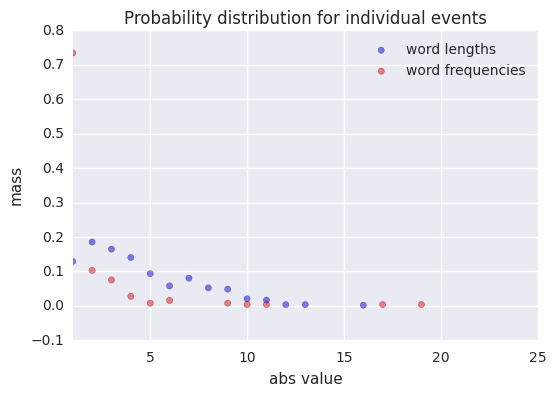

In [179]:
plt.scatter(len_counter.keys(), np.array(len_counter.values())*1.0/sum(len_counter.values()), 
            c="blue", label="word lengths", alpha=0.5)
plt.xlim(1, 25)
# plt.ylim(1, 2600)

_freqC = Counter(freq_counter.values())
plt.scatter(_freqC.keys(), np.array(_freqC.values())*1.0/sum(_freqC.values()), 
            c="red", label="word frequencies", alpha=0.5)
plt.xlim(1, 25)
# plt.ylim(1, 1500)
plt.xlabel("abs value")
plt.ylabel("mass")

plt.legend()
plt.title("Probability distribution for individual events")
print "Probability distribution for individual events"

### To find the distribution for the combined event, we will have to consider the entire joint sample space.

In [180]:
uniq_lengths = len(len_counter.keys())
uniq_freqs = len(_freqC.keys())
print "total unique word lengths:", len(len_counter.keys()), len_counter.keys()
print "total unique word frequencies:", len(_freqC.keys()), _freqC.keys()[:25]

total unique word lengths: 14 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16]
total unique word frequencies: 14 [1, 2, 3, 4, 5, 6, 33, 9, 10, 11, 44, 17, 19, 26]


We now find support for every possible combination in a UNIQ_LENGTHS x UNIQ_FREQUENCIES matrix; i.e. how many words had a length of 1 and a frequency of 128? ... and so on.

To make things easier, we can create a lookup for every words (length, frequency) and then iterate over every word to populate the matrix.

# !!!!! MARGINALIZING OVER THE FREQUENCY TO GET THE TOTAL COUNT FOR A LENGTH SHOULD NOT BE DONE BY SIMPLY SUMMING OVER THE 1st AXIS !!!!!!
The matrix representation can be a bit mis-leading since the 1st dimension captures the number of ocurrences. Hence, to *CORRECTLY* marginalize over the axis=1, we must multiply the number in the cell with the actual number of occurences which can be derived from the **`freqs_mapping`** variable.

For example, to find the frequency of length **1** words, we add all the counts in row0 multiplied by the number of times they have actually ocurred. So, if joint_counts[0,0] == 15 it implies that 15 words with length of 1 have ocurred 1 time; therefore their total frequency is 15\*1. If joint_counts[0, 1] == 12 it implies that 12 words with length of 1 have ocurred 2 times(as **`freqs_mapping`** says column1 maps to 2); therefore its toral frequency will be 12\*2.

### NOTE: I have since updated the joint_counts to be populated by the actual(multiplied) counts, so summing over axis=1 would marginalize correctly.

In [181]:
joint_counts = np.zeros((uniq_lengths, uniq_freqs), dtype=np.int32) ## lengths X frequencies
lengths_mapping = {l:ix for ix,l in enumerate(sorted(len_counter.keys()))}
rev_lengths = sorted(len_counter.keys())
freqs_mapping = {f:ix for ix,f in enumerate(sorted(_freqC.keys()))}
rev_freqs = sorted(_freqC.keys())

print joint_counter.items()[:10]
for word, (l,f) in joint_counter.iteritems():
    _ml, _mf = lengths_mapping[l], freqs_mapping[f]
    joint_counts[_ml, _mf] += 1*f

[('all', [3, 4]), ('words', [5, 1]), ('just', [4, 1]), ('avraham', [7, 1]), ('september', [9, 3]), ('indeed', [6, 1]), ('heartfelt', [9, 1]), ('both', [4, 1]), ('displayed', [9, 1]), ('bombed', [6, 1])]


In [182]:
print len_counter[1], len_counter[2], np.sum(joint_counts, axis=1)
print len_counter[1]*1.0/(uniq_freqs*uniq_lengths), len_counter[2]*1.0/(uniq_freqs*uniq_lengths)

print sum(_freqC.values()), _word_counter

69 99 [69 99 88 75 50 31 43 28 26 11  9  2  2  1]
0.352040816327 0.505102040816
252 534


In [185]:
np.sum(joint_distribution, axis=1)

array([ 0.129,  0.186,  0.164,  0.141,  0.093,  0.058,  0.08 ,  0.051,
        0.049,  0.021,  0.017,  0.004,  0.004,  0.002])

In [183]:
joint_distribution = np.round(joint_counts * 1.0 / (_word_counter), 3)
df = pd.DataFrame(data=joint_distribution)
df.columns = ["freq_"+str(i) for i in rev_freqs]
df.index = ["len_"+str(i) for i in rev_lengths]
print "Joint probability distribution for LENGTHS AND FREQUENCIES:\n"
df

Joint probability distribution for LENGTHS AND FREQUENCIES:



,freq_1,freq_2,freq_3,freq_4,freq_5,freq_6,freq_9,freq_10,freq_11,freq_17,freq_19,freq_26,freq_33,freq_44
len_1,0.007,0.000,0.006,0.007,0.000,0.011,0.000,0.000,0.000,0.000,0.036,0.000,0.062,0.000
len_2,0.006,0.019,0.022,0.000,0.000,0.022,0.017,0.019,0.000,0.032,0.000,0.049,0.000,0.000
len_3,0.021,0.007,0.017,0.007,0.009,0.000,0.000,0.000,0.021,0.000,0.000,0.000,0.000,0.082
len_4,0.066,0.019,0.006,0.022,0.000,0.011,0.017,0.000,0.000,0.000,0.000,0.000,0.000,0.000
len_5,0.054,0.022,0.017,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
len_6,0.043,0.004,0.011,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
len_7,0.047,0.011,0.006,0.007,0.009,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
len_8,0.037,0.007,0.000,0.007,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
len_9,0.028,0.004,0.017,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
len_10,0.015,0.000,0.006,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


### b. Compute entropy over each distributions.

**Note that while calculating the entropy for the joint distribution, we cannot calculate it for every entry in the matrix. One reason is that every 0 entry is an event that NEVER ocurred - there does not exist a 7 length word which ocurred 44 times. The second reason is that taking a log over 0 will cause nan issues. So, instead of iteratively dropping the zeros while calculating the entropy, I just add a very small number while taking the log. While this will not affect non-zero elements, it would safely compute the log for 0 elements, which would then be multiplied by their mass(0) and thus will have no effect on the net entropy. **

In [187]:
h_lengths = -np.sum(np.sum(joint_distribution, axis=1)*np.log2(np.sum(joint_distribution, axis=1)))
print "entropy- lengths distribution:", h_lengths

h_freqs = -np.sum(np.sum(joint_distribution, axis=0)*np.log2(np.sum(joint_distribution, axis=0)))
print "entropy- frequencies distribution:", h_freqs

h_joint = -np.sum(joint_distribution*np.log2(joint_distribution+1e-30))
print "entropy- joint distribution:", h_joint

entropy- lengths distribution: 3.23797245239
entropy- frequencies distribution: 3.2027313376
entropy- joint distribution: 5.17309076583


c. Compute conditional entropies and mutual information

In [188]:
print "H(len | freq)", h_joint - h_freqs
print "H(freq | len)", h_joint - h_lengths
print "I(len , freqs)", h_freqs + h_lengths - h_joint

H(len | freq) 1.97035942823
H(freq | len) 1.93511831344
I(len , freqs) 1.26761302416
